# Implémentation d'un Modèle CatBoost pour l'Optimisation des Ressources d'un Système de Vélos Partagés

Ce projet vise à développer un modèle prédictif multi-cibles pour anticiper en temps réel l'offre et la demande dans les stations de vélos en libre-service (ex: Vélib'). En exploitant des données OpenData (Paris) incluant des variables temporelles, météorologiques et l'historique d'utilisation, l'objectif principal est de prédire simultanément le nombre de vélos disponibles et le nombre de bornettes libres par station.

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
print("="*50)
print("CHARGEMENT DES DONNÉES")
print("="*50)

data = pd.read_csv('../data/data-11-12-25.csv', sep=";")
print(f"Shape du dataset: {data.shape}")
print(f"Colonnes: {list(data.columns)}")

CHARGEMENT DES DONNÉES
Shape du dataset: (1503, 15)
Colonnes: ['Identifiant station', 'Nom station', 'Station en fonctionnement', 'Capacité de la station', 'Nombre bornettes libres', 'Nombre total vélos disponibles', 'Vélos mécaniques disponibles', 'Vélos électriques disponibles', 'Borne de paiement disponible', 'Retour vélib possible', 'Actualisation de la donnée', 'Coordonnées géographiques', 'Nom communes équipées', 'Code INSEE communes équipées', 'station_opening_hours']


In [184]:
data.head()

,Identifiant station,Nom station,Station en fonctionnement,Capacité de la station,Nombre bornettes libres,Nombre total vélos disponibles,Vélos mécaniques disponibles,Vélos électriques disponibles,Borne de paiement disponible,Retour vélib possible,Actualisation de la donnée,Coordonnées géographiques,Nom communes équipées,Code INSEE communes équipées,station_opening_hours
0,32304,Charcot - Benfleet,OUI,28,19,9,0,9,OUI,OUI,2025-12-11T06:18:27+00:00,"48.878370277021, 2.440523876268",Romainville,93063,NaN
1,16107,Benjamin Godard - Victor Hugo,OUI,35,17,16,5,11,OUI,OUI,2025-12-11T06:18:16+00:00,"48.865983, 2.275725",Paris,75056,NaN
2,9020,Toudouze - Clauzel,OUI,21,16,4,0,4,OUI,OUI,2025-12-11T06:10:40+00:00,"48.87929591733507, 2.3373600840568547",Paris,75056,NaN
3,40001,Hôpital Mondor,OUI,28,13,15,6,9,OUI,OUI,2025-12-11T06:18:10+00:00,"48.798922410229, 2.4537451531298",Créteil,94028,NaN
4,14111,Cassini - Denfert-Rochereau,OUI,25,20,5,1,4,OUI,OUI,2025-12-11T06:16:10+00:00,"48.837525839067, 2.3360354080796",Paris,75056,NaN


In [185]:
# Séparation features/target
Y = data[["Nombre total vélos disponibles", "Nombre bornettes libres"]]
X = data.drop(columns=Y.columns, inplace=False)

In [186]:
# Identification des features catégorielles
categorical_features = data[data.columns[data.dtypes == "object"]].columns.tolist()

print("="*50)
print("FEATURES CATEGORICIELLES IDENTIFIES")
print("="*50)
print(f"{categorical_features}")

FEATURES CATEGORICIELLES IDENTIFIES
['Nom station', 'Station en fonctionnement', 'Borne de paiement disponible', 'Retour vélib possible', 'Actualisation de la donnée', 'Coordonnées géographiques', 'Nom communes équipées']


In [187]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

print("="*50)
print("REPARTITION DES JEUX DE DONNEES")
print("="*50)

print(f"Train: {len(X_train)} échantillons ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_valid)} échantillons ({len(X_valid)/len(X)*100:.1f}%)")

REPARTITION DES JEUX DE DONNEES
Train: 1202 échantillons (80.0%)
Validation: 301 échantillons (20.0%)


In [197]:
print("\n" + "="*50)
print("OPTIMISATION DES HYPERPARAMÈTRES")
print("="*50)

def random_search_catboost(x_train, y_train):

    param_dist = {
        'depth': [4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
        'l2_leaf_reg': [0.5, 1, 2, 3, 5, 7, 10],
        'iterations': [300, 400, 500, 600, 700, 800],
        'border_count': [32, 64, 128, 254],
        'random_strength': [0.5, 1, 2, 3]
    }


    base_model = CatBoostRegressor(
        loss_function='MultiRMSE',
        cat_features=categorical_features,
        early_stopping_rounds=50,
        random_seed=42,
        verbose=0
    )

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=5,
        cv=TimeSeriesSplit(n_splits=2),
        n_jobs=-1,
        verbose=1,
        random_state=42,
        scoring='neg_mean_squared_error'
    )


    random_search.fit(x_train, y_train)

    print(f"\nMeilleurs paramètres: {random_search.best_params_}")
    print(f"Meilleur score: {-random_search.best_score_:.4f}")

    return random_search.best_estimator_, random_search.best_params_


best_model, best_params = random_search_catboost(X_train, Y_train)

best_model, best_params


OPTIMISATION DES HYPERPARAMÈTRES
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Meilleurs paramètres: {'random_strength': 3, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'iterations': 500, 'depth': 4, 'border_count': 254}
Meilleur score: 4.3930


(<catboost.core.CatBoostRegressor at 0x735e43cac980>,
 {'random_strength': 3,
  'learning_rate': 0.1,
  'l2_leaf_reg': 2,
  'iterations': 500,
  'depth': 4,
  'border_count': 254})

In [189]:
print("\n" + "="*50)
print("ENTRAÎNEMENT FINAL DU MODÈLE OPTIMAL")
print("="*50)

final_model = CatBoostRegressor(
    **best_params,
    loss_function='MultiRMSE',
    cat_features=categorical_features,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)


train_start = datetime.now()
final_model.fit(
    X_train, Y_train,
    eval_set=(X_valid, Y_valid),
)

train_time = (datetime.now() - train_start).total_seconds()
print(f"Temps d'entraînement: {train_time:.2f} secondes")


ENTRAÎNEMENT FINAL DU MODÈLE OPTIMAL
0:	learn: 14.5196914	test: 14.1954102	best: 14.1954102 (0)	total: 11.5ms	remaining: 5.76s
100:	learn: 2.6755882	test: 3.1329628	best: 3.1329628 (100)	total: 291ms	remaining: 1.15s
200:	learn: 1.8474267	test: 2.5811900	best: 2.5768652 (195)	total: 472ms	remaining: 703ms
300:	learn: 1.5735154	test: 2.4808681	best: 2.4808681 (300)	total: 679ms	remaining: 449ms
400:	learn: 1.4265380	test: 2.4621791	best: 2.4618507 (399)	total: 883ms	remaining: 218ms
499:	learn: 1.3173045	test: 2.4314873	best: 2.4313496 (498)	total: 1.09s	remaining: 0us

bestTest = 2.431349631
bestIteration = 498

Shrink model to first 499 iterations.
Temps d'entraînement: 1.23 secondes


In [194]:
print("\n" + "="*50)
print("ÉVALUATION DU MODÈLE")
print("="*50)

pred_train = final_model.predict(X_train)
pred_valid = final_model.predict(X_valid)

# Fonction d'évaluation avec visualisations
def detailed_evaluation_with_viz(y_true, y_pred, dataset_name=""):
    """Évaluation complète avec visualisations"""

    # Calcul des métriques pour affichage texte
    print(f"\n{'='*30}")
    print(f"ÉVALUATION {dataset_name}")
    print(f"{'='*30}")

    metrics_data = []

    for i, col in enumerate(['Vélos disponibles', 'Bornettes libres']):
        print(f"\n--- {col} ---")

        # Métriques de base
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])

        # Métriques additionnelles
        mape = np.mean(np.abs((y_true.iloc[:, i] - y_pred[:, i]) /
                             np.maximum(y_true.iloc[:, i], 1))) * 100
        max_error = np.max(np.abs(y_true.iloc[:, i] - y_pred[:, i]))

        y_mean = y_true.iloc[:, i].mean()
        cv_rmse = (rmse / y_mean) * 100 if y_mean != 0 else np.nan

        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  Erreur maximale: {max_error:.2f}")
        print(f"  CV-RMSE: {cv_rmse:.2f}%")

        errors = y_true.iloc[:, i] - y_pred[:, i]
        print(f"  Erreur moyenne: {errors.mean():.4f}")
        print(f"  Std des erreurs: {errors.std():.4f}")
        print(f"  Erreurs dans [-3,3]: {((errors >= -3) & (errors <= 3)).mean()*100:.1f}%")

        metrics_data.append({
            'target': col,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape,
            'errors': errors
        })

    return metrics_data

# Évaluation et collecte des données
print("\n📊 Calcul des métriques...")
metrics_train = detailed_evaluation_with_viz(Y_train, pred_train, "TRAIN")
metrics_valid = detailed_evaluation_with_viz(Y_valid, pred_valid, "VALIDATION")


ÉVALUATION DU MODÈLE

📊 Calcul des métriques...

ÉVALUATION TRAIN

--- Vélos disponibles ---
  RMSE: 0.4876
  MAE: 0.3641
  R²: 0.9974
  MAPE: 5.12%
  Erreur maximale: 3.96
  CV-RMSE: 4.03%
  Erreur moyenne: 0.0152
  Std des erreurs: 0.4876
  Erreurs dans [-3,3]: 99.9%

--- Bornettes libres ---
  RMSE: 1.4203
  MAE: 0.9884
  R²: 0.9850
  MAPE: 11.60%
  Erreur maximale: 15.39
  CV-RMSE: 7.60%
  Erreur moyenne: -0.0467
  Std des erreurs: 1.4201
  Erreurs dans [-3,3]: 97.3%

ÉVALUATION VALIDATION

--- Vélos disponibles ---
  RMSE: 1.3453
  MAE: 0.5921
  R²: 0.9822
  MAPE: 5.47%
  Erreur maximale: 13.45
  CV-RMSE: 10.85%
  Erreur moyenne: 0.2019
  Std des erreurs: 1.3323
  Erreurs dans [-3,3]: 99.0%

--- Bornettes libres ---
  RMSE: 2.0253
  MAE: 1.2942
  R²: 0.9646
  MAPE: 16.25%
  Erreur maximale: 16.09
  CV-RMSE: 11.18%
  Erreur moyenne: -0.2204
  Std des erreurs: 2.0166
  Erreurs dans [-3,3]: 94.0%



📊 GRAPHIQUES POUR: VÉLOS DISPONIBLES


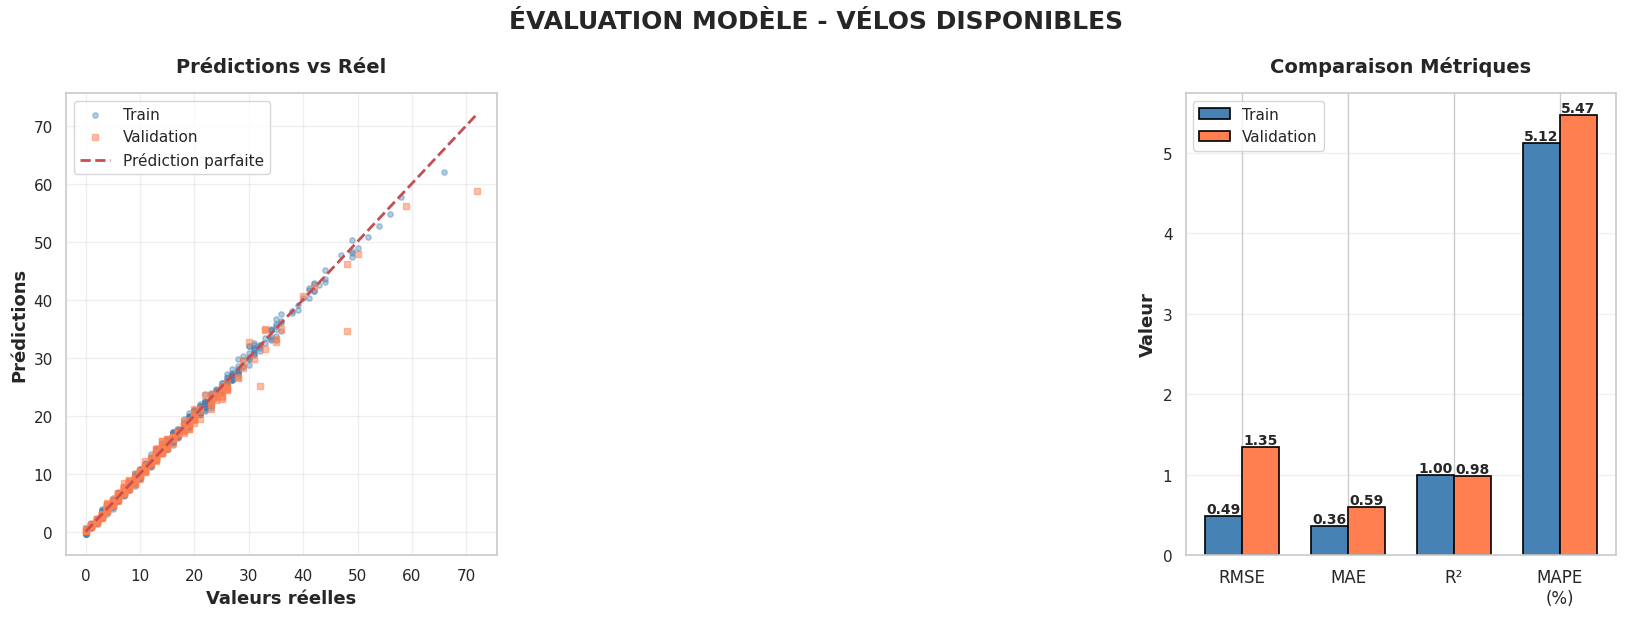


📊 GRAPHIQUES POUR: BORNETTES LIBRES


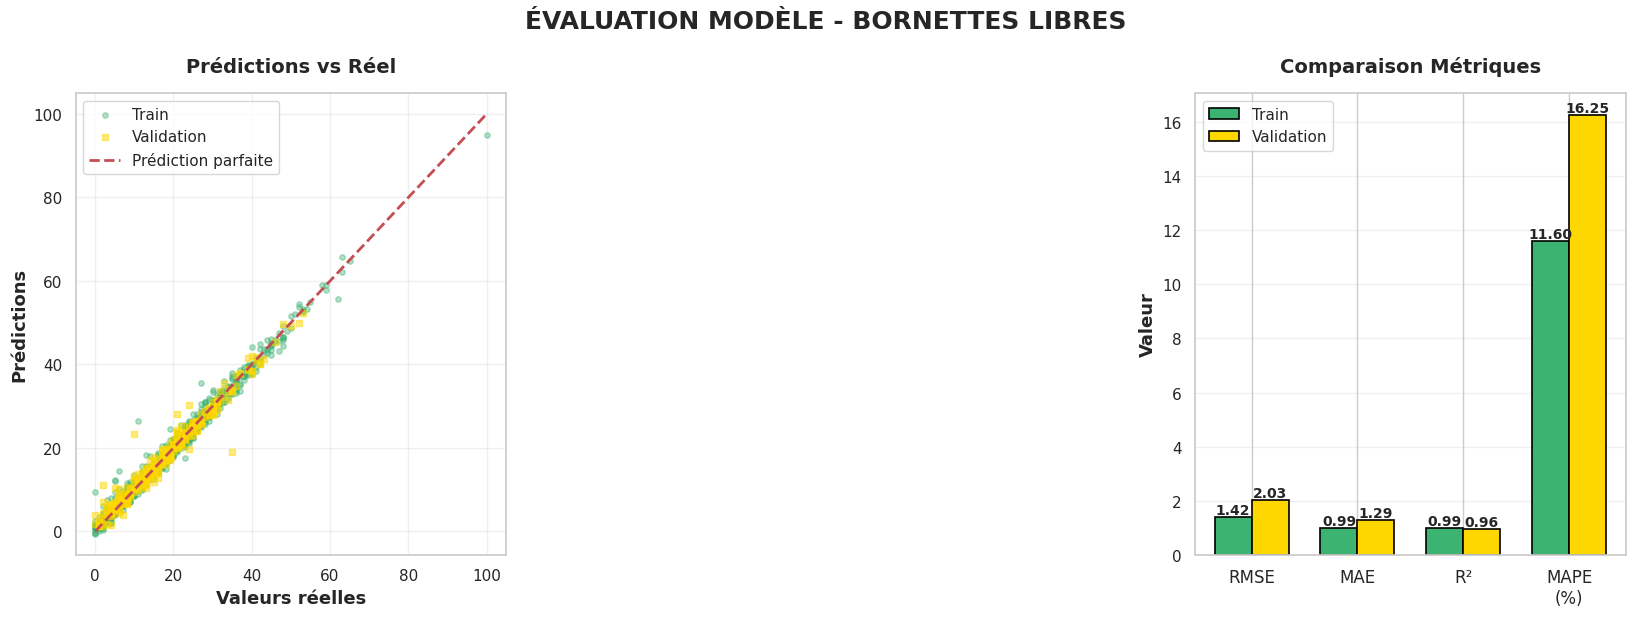

In [195]:
targets = ['Vélos disponibles', 'Bornettes libres']
colors_train = ['steelblue', 'mediumseagreen']
colors_valid = ['coral', 'gold']

for idx, target in enumerate(targets):

    print(f"\n{'='*50}")
    print(f"📊 GRAPHIQUES POUR: {target.upper()}")
    print(f"{'='*50}")

    # Créer une figure séparée pour chaque cible
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

    # --- 1. PRÉDICTIONS VS RÉEL (Scatter) ---
    ax1 = fig.add_subplot(gs[0, 0])

    # Train
    ax1.scatter(Y_train.iloc[:, idx], pred_train[:, idx],
                alpha=0.4, s=15, color=colors_train[idx], label='Train')
    # Validation
    ax1.scatter(Y_valid.iloc[:, idx], pred_valid[:, idx],
                alpha=0.5, s=20, color=colors_valid[idx], label='Validation', marker='s')

    # Ligne parfaite
    min_val = min(Y_train.iloc[:, idx].min(), Y_valid.iloc[:, idx].min())
    max_val = max(Y_train.iloc[:, idx].max(), Y_valid.iloc[:, idx].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prédiction parfaite')

    ax1.set_xlabel('Valeurs réelles', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Prédictions', fontsize=13, fontweight='bold')
    ax1.set_title('Prédictions vs Réel', fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(alpha=0.3)



    # --- 3. MÉTRIQUES COMPARATIVES (Barplot) ---
    ax3 = fig.add_subplot(gs[0, 2])

    metric_names = ['RMSE', 'MAE', 'R²', 'MAPE\n(%)']
    train_vals = [metrics_train[idx]['rmse'], metrics_train[idx]['mae'],
                  metrics_train[idx]['r2'], metrics_train[idx]['mape']]
    valid_vals = [metrics_valid[idx]['rmse'], metrics_valid[idx]['mae'],
                  metrics_valid[idx]['r2'], metrics_valid[idx]['mape']]

    x_pos = np.arange(len(metric_names))
    width = 0.35

    bars1 = ax3.bar(x_pos - width/2, train_vals, width, label='Train',
                    color=colors_train[idx], edgecolor='black', linewidth=1.2)
    bars2 = ax3.bar(x_pos + width/2, valid_vals, width, label='Validation',
                    color=colors_valid[idx], edgecolor='black', linewidth=1.2)

    # Ajouter valeurs sur barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(metric_names, fontsize=12)
    ax3.set_ylabel('Valeur', fontsize=13, fontweight='bold')
    ax3.set_title('Comparaison Métriques', fontsize=14, fontweight='bold', pad=15)
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3, axis='y')

    # Titre principal pour la figure
    fig.suptitle(f'ÉVALUATION MODÈLE - {target.upper()}',
                 fontsize=18, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.savefig(f'{target.upper()}.png')
    plt.show()


ANALYSE D'IMPORTANCE DES FEATURES
                      Feature  Importance
 Vélos mécaniques disponibles   43.797732
       Capacité de la station   42.627225
Vélos électriques disponibles   10.513241
        Nom communes équipées    1.121586
          Identifiant station    0.912896


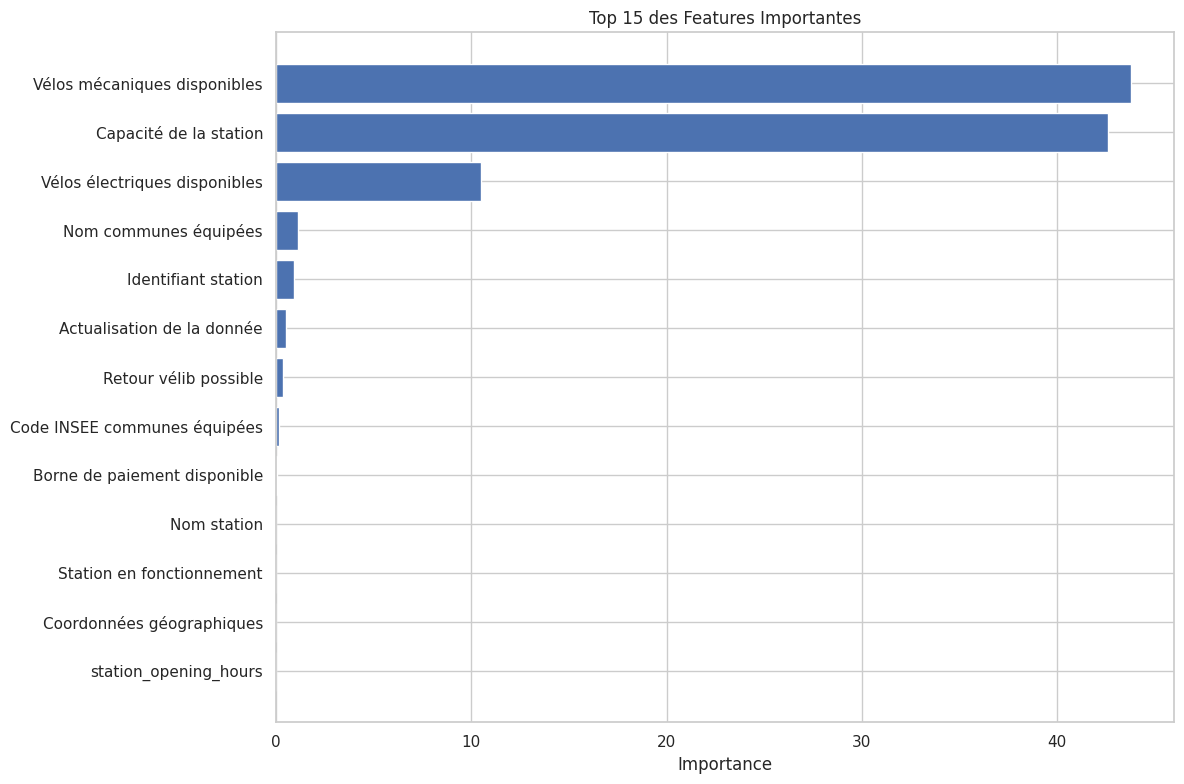

In [196]:
print("\n" + "="*50)
print("ANALYSE D'IMPORTANCE DES FEATURES")
print("="*50)

feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df.head().to_string(index=False))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 des Features Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top-15-importances.png')
plt.show()

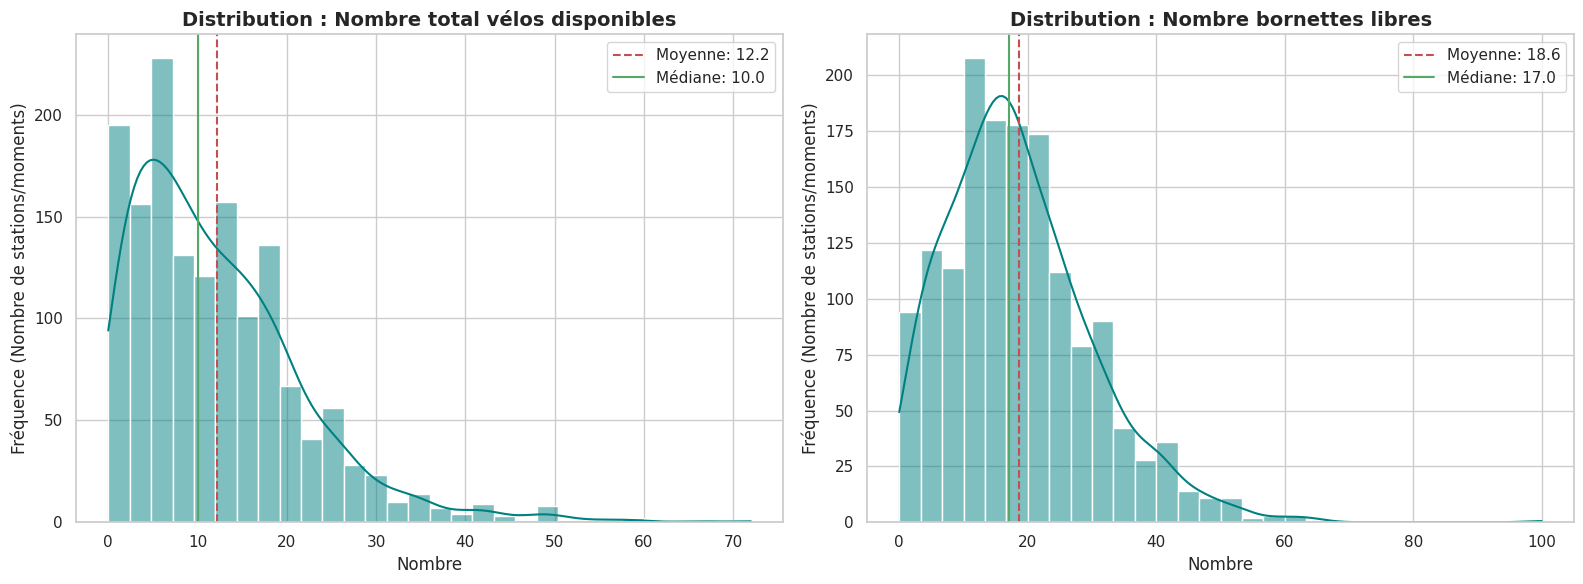

In [193]:
def plot_target_distribution(Y):
    """
    Affiche la distribution des variables cibles pour détecter
    les déséquilibres de classes
    """
    cols = Y.columns
    n_cols = len(cols)

    fig, axes = plt.subplots(1, n_cols, figsize=(16, 6))
    if n_cols == 1: axes = [axes]

    for i, col in enumerate(cols):
        # 1. Histogramme avec courbe de densité (KDE)
        sns.histplot(Y[col], kde=True, ax=axes[i], color='teal', bins=30)

        # Lignes pour la moyenne et la médiane
        mean_val = Y[col].mean()
        median_val = Y[col].median()
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Moyenne: {mean_val:.1f}')
        axes[i].axvline(median_val, color='g', linestyle='-', label=f'Médiane: {median_val:.1f}')

        axes[i].set_title(f'Distribution : {col}', fontsize=14, fontweight='bold')
        axes[i].legend()
        axes[i].set_xlabel('Nombre')
        axes[i].set_ylabel('Fréquence (Nombre de stations/moments)')

    plt.tight_layout()
    plt.savefig('distribution.png')
    plt.show()

plot_target_distribution(Y)